## Import packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'  # 安装graphviz的路径，用于模型可视化

In [3]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Input, SpatialDropout1D, Bidirectional
from keras.layers.recurrent import LSTM, GRU
from keras import backend as K
from keras.preprocessing import sequence, text
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

Using TensorFlow backend.


## Hyper parameter setting

In [4]:
token = 'words' # based on words or chars
embed_size = 300 # how big is each word vector
max_features = 20890 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 15 # max number of words in a comment to use
num_rnn_units = 128
num_hidden_units = 300
drop_prob = 0.2
max_norm = 5.0
filter_sizes = [1,2,3,5]
num_filters = 128

## File path

In [5]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
QUESTION_PATH = './question.csv'
embed_files = {'words': './word_embed.txt', 'chars': './char_embed.txt'}

## Some helper function

In [6]:
# Get question id from a list. Remove the Q
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

# Get the text
def get_texts(q_list, question_path=QUESTION_PATH):
    qes = pd.read_csv(question_path)
    ids = get_ids(q_list)
    all_tokens = qes[token]
    texts = [all_tokens[t] for t in ids]
    return texts

## Read the text

#### Train data
split some data for validation

In [7]:
train = pd.read_csv(TRAIN_PATH)
list_train = list(zip(train['q1'], train['q2']))
label_train = train['label']
#print(len(list_train), len(label_train))

X_tra, X_val, y_tra, y_val = train_test_split(list_train, label_train, train_size=0.85, random_state=11, shuffle=True)

# get the text list of question 1 and 2
q1_train = [i[0] for i in X_tra]
text1_train = get_texts(q1_train)
q2_train = [i[1] for i in X_tra]
text2_train = get_texts(q2_train)
q1_val = [i[0] for i in X_val]
text1_val = get_texts(q1_val)
q2_val = [i[1] for i in X_val]
text2_val = get_texts(q2_val)

C:\Users\SJ\AppData\Local\conda\conda\envs\deep\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Test data

In [8]:
test = pd.read_csv(TEST_PATH)
list_test = list(zip(test['q1'], test['q2']))

# get the text list of question 1 and 2
q1_test = [i[0] for i in list_test]
text1_test = get_texts(q1_test)
q2_test = [i[1] for i in list_test]
text2_test = get_texts(q2_test)

## Tokenize

In [9]:
tokenizer = Tokenizer(num_words=max_features, lower=False) # Don't lower the W or L!!!
tokenizer.fit_on_texts(pd.read_csv(QUESTION_PATH)[token])

# train set
tokenized1_train = tokenizer.texts_to_sequences(text1_train)
tokenized2_train = tokenizer.texts_to_sequences(text2_train)
X1_train = pad_sequences(tokenized1_train, maxlen=maxlen)
X2_train = pad_sequences(tokenized2_train, maxlen=maxlen)

# validation set
tokenized1_val = tokenizer.texts_to_sequences(text1_val)
tokenized2_val = tokenizer.texts_to_sequences(text2_val)
X1_val = pad_sequences(tokenized1_val, maxlen=maxlen)
X2_val = pad_sequences(tokenized2_val, maxlen=maxlen)

# test set
tokenized1_test = tokenizer.texts_to_sequences(text1_test)
tokenized2_test = tokenizer.texts_to_sequences(text2_test)
X1_test = pad_sequences(tokenized1_test, maxlen=maxlen)
X2_test = pad_sequences(tokenized2_test, maxlen=maxlen)

## Prepare the pretrained word embedding

In [10]:
def get_coefs(line): return line[0], np.asarray(line[1:], dtype='float32')
embed_file = embed_files[token]
embeddings_index = dict(get_coefs(o.strip().split()) for o in open(embed_file, encoding='utf-8'))
print (len(embeddings_index.items()))
#print (list(embeddings_index.items())[20890])

20891


In [11]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.015683081, 1.1956546)

In [12]:
word_index = tokenizer.word_index
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features+1, embed_size))

for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    #print (i, word, len(embedding_vector))
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [13]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

## Build the model

In [14]:
from keras import backend as K
K.clear_session()

In [15]:
inp1 = Input(shape=(maxlen,))
inp2 = Input(shape=(maxlen,))

# basic cnn+rnn model
inp = Input(shape=(maxlen,))
h = Embedding(max_features+1, embed_size, weights=[embedding_matrix], trainable=True)(inp)
h = SpatialDropout1D(drop_prob)(h)
h = Bidirectional(LSTM(num_rnn_units, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob))(h)
    
conv_0 = Conv1D(num_filters, kernel_size=filter_sizes[0], padding = "valid", activation = 'relu')(h)
conv_1 = Conv1D(num_filters, kernel_size=filter_sizes[1], padding = "valid", activation = 'relu')(h)
conv_2 = Conv1D(num_filters, kernel_size=filter_sizes[2], padding = "valid", activation = 'relu')(h)
conv_3 = Conv1D(num_filters, kernel_size=filter_sizes[3], padding = "valid", activation = 'relu')(h)
maxpool_0 = GlobalMaxPooling1D()(conv_0)
avgpool_0 = GlobalAveragePooling1D()(conv_0)
maxpool_1 = GlobalMaxPooling1D()(conv_1)
avgpool_1 = GlobalAveragePooling1D()(conv_1)
maxpool_2 = GlobalMaxPooling1D()(conv_2)
avgpool_2 = GlobalAveragePooling1D()(conv_2)
maxpool_3 = GlobalMaxPooling1D()(conv_3)
avgpool_3 = GlobalAveragePooling1D()(conv_3)

z = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3, avgpool_0, avgpool_1, avgpool_2, avgpool_3])

base_model = Model(inputs=inp, outputs=z)

o1 = base_model(inp1)
o2 = base_model(inp2)

conc = concatenate([o1,o2])
x = BatchNormalization()(conc)

x = Dense(num_hidden_units, activation='relu')(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[inp1, inp2], outputs=x)

adam = optimizers.Adam(clipnorm=max_norm)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model11.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1024)         7067556     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 2048)         0           model_1[1][0]                    
          

## Train the model

In [16]:
cp = ModelCheckpoint(filepath="my_model11.h5", save_best_only=True)
es = EarlyStopping(patience=4)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit([X1_train, X2_train], y_tra, batch_size = 256, epochs=30, validation_data=([X1_val, X2_val], y_val), callbacks=[cp, es, rp])

Train on 216228 samples, validate on 38158 samples
Epoch 1/30
216228/216228 [==============================] - 83s 383us/step - loss: 0.4585 - acc: 0.7836 - val_loss: 0.3387 - val_acc: 0.8489
Epoch 2/30
216228/216228 [==============================] - 77s 358us/step - loss: 0.3339 - acc: 0.8518 - val_loss: 0.2907 - val_acc: 0.8707
Epoch 3/30
216228/216228 [==============================] - 77s 358us/step - loss: 0.2840 - acc: 0.8762 - val_loss: 0.2540 - val_acc: 0.8901
Epoch 4/30
216228/216228 [==============================] - 79s 366us/step - loss: 0.2508 - acc: 0.8923 - val_loss: 0.2372 - val_acc: 0.9011
Epoch 5/30
216228/216228 [==============================] - 78s 362us/step - loss: 0.2264 - acc: 0.9040 - val_loss: 0.2215 - val_acc: 0.9059
Epoch 6/30
216228/216228 [==============================] - 77s 354us/step - loss: 0.2076 - acc: 0.9134 - val_loss: 0.2167 - val_acc: 0.9103
Epoch 7/30
216228/216228 [==============================] - 80s 368us/step - loss: 0.1914 - acc: 0.9195

## check the loss curve

{'val_loss': [0.33867928850287765, 0.29066097744481295, 0.2539949700829118, 0.23723506890782095, 0.22145563452128464, 0.21670218764988966, 0.21663831424535687, 0.21047602605301727, 0.21108358808362052, 0.2116915246489238, 0.21156324067795088, 0.2114531182748878], 'val_acc': [0.8489438649855655, 0.8706955291064095, 0.8901409927051306, 0.9011216520813252, 0.90594370774462, 0.9103464542198021, 0.9120236909722524, 0.9151423030588398, 0.9165836783929768, 0.9165050579202058, 0.916714712514262, 0.9165836783929768], 'loss': [0.4585069342285793, 0.33385557465469307, 0.28397650812175096, 0.2507942101699031, 0.22635987442274377, 0.2075881967404941, 0.19141293502141507, 0.16046838805848265, 0.15028927651565224, 0.1422973505443228, 0.14128396121112202, 0.14190482554849523], 'acc': [0.7836404166116295, 0.8518092013874975, 0.8762463695574215, 0.8923451171977288, 0.9040364800052236, 0.9134293430809537, 0.9195247608994283, 0.9341944614139824, 0.9386943411528937, 0.9421027804061867, 0.9426531253903313, 

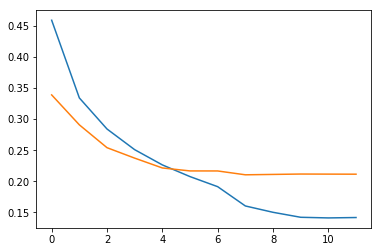

In [17]:
print (hist.history)
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])

## Load the model

In [18]:
from keras.models import load_model
model = load_model('my_model11.h5')

## predict the test data

In [19]:
y_pred = model.predict([X1_test, X2_test], batch_size=1024)

In [20]:
# To make a submission file 
def make_submission(predict_prob):
    with open('sub11.csv', 'w') as file:
        file.write(str('y_pre') + '\n')
        for line in predict_prob:
            #line = np.clip(line, 0.005, 0.995)
            file.write(str(line[0]) + '\n')
    file.close()
    
make_submission(y_pred)